# Exploring Trends in the NSDUH Data Set

In [32]:
from os import path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='white')

import thinkstats2 as ts
import thinkplot

oxy_file = 'oxy.hdf5'

For this project, I'm exploring 11 years of NSDUH data to look for trends in oxycontin use.

The survey series can be found on the [SAMHDA website](https://www.datafiles.samhsa.gov/study-series/national-survey-drug-use-and-health-nsduh-nid13517).

The codebooks can be found by clicking through the [NSDUH page on SAMHDA](https://www.datafiles.samhsa.gov/study-series/national-survey-drug-use-and-health-nsduh-nid13517)

The terms of use for this data can be found on the [SAMHDA website's terms of use page](https://www.datafiles.samhsa.gov/info/terms-use-nid3422)

In [33]:
def add_year_column(year, df):
    """Add a column 'year' to a dataframe for identification purposes.
    
    Args:
        year (int): The year value of the column.
        df (pandas dataframe): The dataframe to add the column to.
    """
    year_arr = np.ones(df.shape[0], dtype=np.int16) * year
    year_col = pd.Series(year_arr, df.index)
    df['year'] = year_col

In [34]:
if not path.exists(oxy_file):
    # Load the data. Each survey year is stored as its own key in the hdf file.
    # See import_data.py for information on how the data was saved.
    nsduh2007 = pd.read_hdf('nsduh.hdf5', 'NSDUH_2007')
    nsduh2008 = pd.read_hdf('nsduh.hdf5', 'NSDUH_2008')
    nsduh2009 = pd.read_hdf('nsduh.hdf5', 'NSDUH_2009')
    nsduh2010 = pd.read_hdf('nsduh.hdf5', 'NSDUH_2010')
    nsduh2011 = pd.read_hdf('nsduh.hdf5', 'NSDUH_2011')
    nsduh2012 = pd.read_hdf('nsduh.hdf5', 'NSDUH_2012')
    nsduh2013 = pd.read_hdf('nsduh.hdf5', 'NSDUH_2013')
    nsduh2014 = pd.read_hdf('nsduh.hdf5', 'NSDUH_2014')
    nsduh2015 = pd.read_hdf('nsduh.hdf5', 'NSDUH_2015')
    nsduh2016 = pd.read_hdf('nsduh.hdf5', 'NSDUH_2016')
    nsduh2017 = pd.read_hdf('nsduh.hdf5', 'NSDUH_2017')

    nsduh_all_years = [nsduh2007,
                       nsduh2008,
                       nsduh2009,
                       nsduh2010,
                       nsduh2011,
                       nsduh2012,
                       nsduh2013,
                       nsduh2014,
                       nsduh2015,
                       nsduh2016,
                       nsduh2017]

    for year, df in zip(range(2007, 2018), nsduh_all_years):
        add_year_column(year, df)

## Prescription Opioids
The most common opiods incvolved in prescription overdose death are Metadone, Oxycodone, and Hydrocodone [according to the CDC](https://www.cdc.gov/drugoverdose/opioids/prescribed.html). I'm going to specifically look at oxycontin because the NSDUH survey provides the most questions targetted at its use as a painkiller.

### Prepare the data

For years 2007 to 2014, the questions pertaining to oxycontin use are:

* 'oxycage': AGE WHEN FIRST USED OXYCONTIN NONMEDICALLY\*
* 'oxycrec': TIME SINCE LAST USED OXYCONTIN NONMEDICALLY\*
* 'oxyyrtot': TOTAL # DAYS USED OXYCONTIN PAST 12 MONTHS
* 'oxdaypyr': # DAYS USED OXYCONTIN "NM" PAST 12 MONTHS

\* "Nonmedically" is defined as usage of the drug that was not prescribed for the individual or usage only for the experience or feeling it caused.

For years 2015 to 2017, the questions pertaining to oxycontin use are:

* 'oxcnnmage': AGE 1ST USED OXYCONTIN NOT DIRECTED BY DR

First, I want to make a dataframe containing these categories for all years. Then, I'll go back and clean it up.

In [35]:
if not path.exists(oxy_file):
    opioids = []
    for nsduh in nsduh_all_years:
        if nsduh['year'][0] < 2015:
            columns = ['oxycage', 'oxycrec', 'oxyyrtot', 'oxdaypyr', 'year', 'AGE2', 'ANALWT_C']
            opioids.append(nsduh.dropna(subset=columns)[columns])
        else:
            columns = ['oxcnnmage', 'year', 'AGE2', 'ANALWT_C']
            opioids.append(nsduh.dropna(subset=columns)[columns])
    opioids[0].head()
    opioid_df = pd.concat(opioids, sort=True)

Replace entries in the dataframe that are coded for missing data. For reference, below is a list of the codes and their descriptions for each variable. These descriptions can also be found in the codebooks for the surveys.

- OXCNNMAGE:
    - 981: NEVER USED PAIN RLVRS Logically assigned
    - 985: BAD DATA Logically assigned
    - 991: NEVER USED/MISUSED PAIN RELIEVERS
    - 993: DID NOT USE IN THE PAST 12 MONTHS
    - 994: DON'T KNOW
    - 997: REFUSED
    - 998: BLANK (NO ANSWER)
- OXYCAGE:
    - 981: NEVER USED OXYCONTIN Logically assigned
    - 985: BAD DATA Logically assigned
    - 991: NEVER USED OXYCONTIN
    - 994: DON'T KNOW
    - 997: REFUSED
    - 998: BLANK (NO ANSWER)
- OXYCREC:
    - 85: BAD DATA Logically assigned
    - 97: REFUSED
    - 98: BLANK (NO ANSWER)
- OXYYRTOT:
    - 981: NEVER USED OXYCONTIN Logically assigned.
    - 985: BAD DATA Logically assigned.
    - 991: NEVER USED OXYCONTIN
    - 993: DID NOT USE OXYCONTIN IN THE PAST 12 MOS
    - 994: DON'T KNOW
    - 997: REFUSED
    - 998: BLANK (NO ANSWER).
- OXDAYPYR:
    - 981: NEVER USED OXYCONTIN Logically assigned
    - 985: BAD DATA Logically assigned
    - 989: LEGITIMATE SKIP Logically assigned
    - 991: NEVER USED OXYCONTIN
    - 993: DID NOT USE OXYCONTIN IN THE PAST 12 MOS
    - 997: REFUSED
    - 998: BLANK (NO ANSWER)
    - 999: LEGITIMATE SKIP

In [36]:
def clean_opioid_df(df):
    """Replace unwanted data codes with NaNs.
    Args:
        df (pandas data frame): A dataframe containing nsduh opioid data.
    """
    df['oxcnnmage'].replace([981, 985, 991, 993, 994, 997, 998], np.nan)
    df['oxycage'].replace([981, 985, 991, 994, 997, 998], np.nan)
    df['oxycrec'].replace([85, 97, 98], np.nan)
    df['oxyyrtot'].replace([985, 994, 997, 998], np.nan)
    # Interpret these categories as using oxycontin for 
    # 0 total days in the last 12 months
    df['oxyyrtot'].replace([981, 991, 993], 0)
    df['oxdaypyr'].replace([985, 989, 994, 997, 998, 999], np.nan)
    # Interpret these categories as using for 0 days in the last 12 months
    df['oxdaypyr'].replace([981, 991, 993], 0)
    
if path.exists(oxy_file):
    print("Loading data from {}".format(oxy_file))
    opioid_df = pd.read_hdf(oxy_file, 'oxycontin')
    
else:
    print("Saving cleaned data to {}".format(oxy_file))
    clean_opioid_df(opioid_df) 
    opioid_df.to_hdf(oxy_file, key='oxycontin', format='table')

Saving cleaned data to oxy.hdf5


In [37]:
opioid_df.head()

,AGE2,ANALWT_C,oxcnnmage,oxdaypyr,oxycage,oxycrec,oxyyrtot,year
0,15,11374.865749,NaN,31.0,48.0,7.0,75.0,2007
1,7,663.978354,NaN,31.0,48.0,7.0,75.0,2007
2,15,16098.457485,NaN,31.0,48.0,7.0,75.0,2007
3,14,9718.353413,NaN,31.0,48.0,7.0,75.0,2007
4,15,1800.895081,NaN,31.0,48.0,7.0,75.0,2007


Let's quickly look at the variables.

In [38]:
for col in opioid_df.columns:
    print(opioid_df[col].describe(), '\n')

count    617121.000000
mean          9.131715
std           4.953009
min           0.000000
25%           5.000000
50%          10.000000
75%          14.000000
max          16.000000
Name: AGE2, dtype: float64 

count    617121.000000
mean       4630.361766
std        6866.806230
min           1.038745
25%         961.494731
50%        2179.507136
75%        5313.845660
max      228011.922662
Name: ANALWT_C, dtype: float64 

count    170319.000000
mean         45.848496
std           4.161621
min           0.000000
25%          42.000000
50%          48.000000
75%          48.000000
max          52.000000
Name: oxcnnmage, dtype: float64 

count    446802.000000
mean         32.862548
std           6.173941
min           0.000000
25%          28.000000
50%          32.000000
75%          37.000000
max          48.000000
Name: oxdaypyr, dtype: float64 

count    446802.000000
mean         49.081560
std           6.996077
min           0.000000
25%          49.000000
50%          50.0000

### Age when first tried oxycontin nonmedically

I'm interested in looking at when people typically try oxycontin nonmedically for the first time. Please note that the plots below are only representative of the people who had tried oxycontin in their lives.

#### Age Distribution
Let's take a look at the distribution of ages of the respondants.

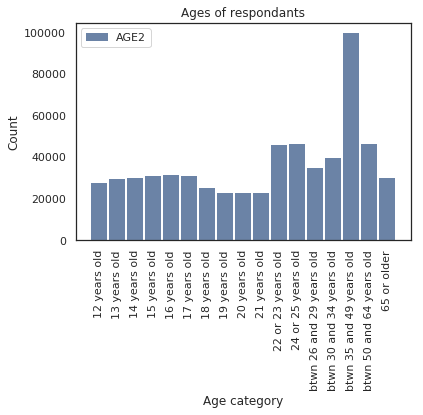

In [63]:
hist_ages = ts.Hist(opioid_df['AGE2'])
thinkplot.hist(hist_ages, label='AGE2')

# For some reason, it looks like the codes for AGE2 were shifted by 1.
ticks = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
labels = ['12 years old',
         '13 years old',
         '14 years old',
         '15 years old',
         '16 years old',
         '17 years old',
         '18 years old',
         '19 years old',
         '20 years old',
         '21 years old',
         '22 or 23 years old',
         '24 or 25 years old',
         'btwn 26 and 29 years old',
         'btwn 30 and 34 years old',
         'btwn 35 and 49 years old',
         'btwn 50 and 64 years old',
         '65 or older']
plt.xticks(ticks, labels, rotation=90)
plt.ylabel('Count')
plt.xlabel('Age category')
plt.title('Ages of respondants')
plt.legend()

There is a large spike in the number of respondants in the 35-49 year category. This is something to watch out for when looking at the ages that people first try Oxycontin.

#### Survey years 2007 to 2014

Text(0, 0.5, 'Count')

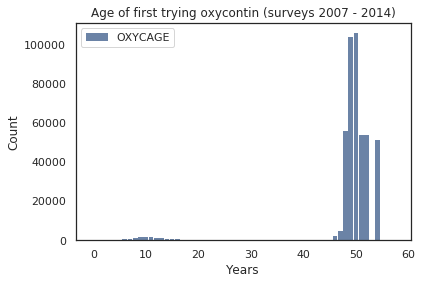

In [39]:
hist_age = ts.Hist(opioid_df['oxycage'])
thinkplot.hist(hist_age, label='OXYCAGE')
plt.legend()
plt.title("Age of first trying oxycontin (surveys 2007 - 2014)")
plt.xlabel("Years")
plt.ylabel("Count")

It looks like the majority of people are middle aged when they try oxycontin nonmedically. I'm not surprised by this fact, based on the age I expect people to be when they are prescribed painkillers for injuries. It's interesting that there is a small section of the histogram centered around 10 years. I'm surprised to see this. My guess would be that the people who tried it when they were extremely young were given it by their parents. I'm less surprised to see some people trying it in their teens, but I might have expected the count to be higher for this age group.

Let's look at the PMF and CDF of the same information.

Text(0, 0.5, 'PMF')

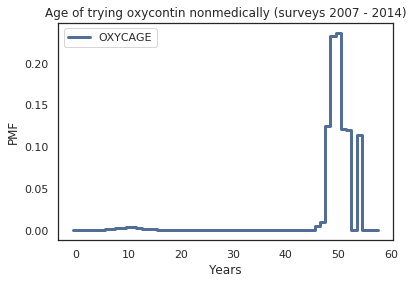

In [40]:
pmf_age = ts.Pmf(opioid_df['oxycage'])
thinkplot.Pmf(pmf_age, label='OXYCAGE')
plt.legend()
plt.title("Age of trying oxycontin nonmedically (surveys 2007 - 2014)")
plt.xlabel("Years")
plt.ylabel("PMF")

Text(0, 0.5, 'PMF')

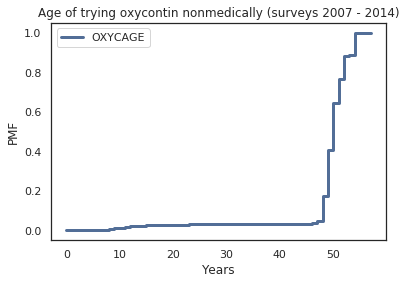

In [41]:
cdf_age = ts.Cdf(opioid_df['oxycage'])
thinkplot.Cdf(cdf_age, label='OXYCAGE')
plt.legend()
plt.title("Age of trying oxycontin nonmedically (surveys 2007 - 2014)")
plt.xlabel("Years")
plt.ylabel("PMF")

These plots confirm what I saw in the histogram. Someone who is over 50 is much more likely to have tried oxycontin nonmedically than younger people.

#### Survey years 2015 to 2017

Let's take a look at the more recent surveys.

Text(0.5, 0, 'year')

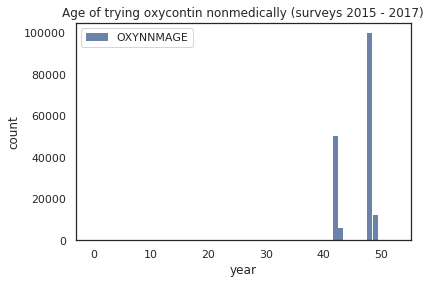

In [42]:
hist_age = ts.Hist(opioid_df['oxcnnmage'])
thinkplot.hist(hist_age, label='OXYNNMAGE')
plt.legend()
plt.title("Age of trying oxycontin nonmedically (surveys 2015 - 2017)")
plt.ylabel('count')
plt.xlabel('year')

Text(0.5, 0, 'year')

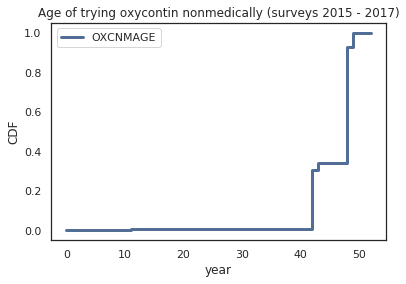

In [43]:
cdf_age = ts.Cdf(opioid_df['oxcnnmage'])
thinkplot.cdf(cdf_age, label='OXCNMAGE')
plt.legend()
plt.title("Age of trying oxycontin nonmedically (surveys 2015 - 2017)")
plt.ylabel("CDF")
plt.xlabel("year")

This data, although much more sparse, seems to follow the same trends as the data from the older surveys. It looks like we're going to have to combine these columns in order to see the full picture.

#### All survey years

In the 2007 through 2014 surveys, the 'oxycage' category contains the answers to the question *"How long has it been since you last used OxyContin that was not prescribed for you or that you took only for the experience or feeling it caused?"*

In the 2015 through 2017 surveys, the 'oxcnnmage' category contains the answers to the question *"How old were you when you first used OxyContin in a way a doctor did not direct you to use it?"*

I'm combining these answers into one column named 'agefirst' to get a fuller picture of the age at which respondants first tried oxycontin across all surveys.

In [44]:
opioid_df['agefirst'] = opioid_df.apply(lambda r: (r['oxycage'] if r['oxycage'] != np.nan else r['oxcnnmage']), axis=1)
opioid_df.head()

,AGE2,ANALWT_C,oxcnnmage,oxdaypyr,oxycage,oxycrec,oxyyrtot,year,agefirst
0,15,11374.865749,NaN,31.0,48.0,7.0,75.0,2007,48.0
1,7,663.978354,NaN,31.0,48.0,7.0,75.0,2007,48.0
2,15,16098.457485,NaN,31.0,48.0,7.0,75.0,2007,48.0
3,14,9718.353413,NaN,31.0,48.0,7.0,75.0,2007,48.0
4,15,1800.895081,NaN,31.0,48.0,7.0,75.0,2007,48.0


Text(0.5, 0, 'age (years)')

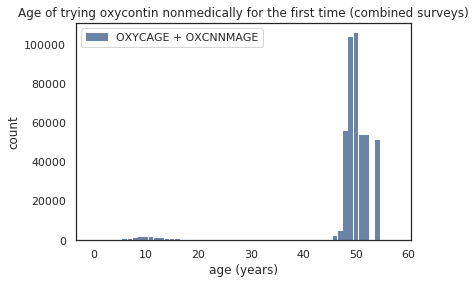

In [45]:
hist_age = ts.Hist(opioid_df['agefirst'])
thinkplot.hist(hist_age, label='OXYCAGE + OXCNNMAGE')
plt.legend()
plt.title('Age of trying oxycontin nonmedically for the first time (combined surveys)')
plt.ylabel('count')
plt.xlabel('age (years)')

Median age: 50.0 IQR: 2.0


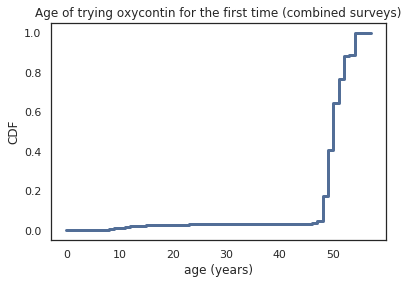

In [46]:
cdf_age = ts.Cdf(opioid_df['agefirst'])
thinkplot.cdf(cdf_age)
plt.title('Age of trying oxycontin for the first time (combined surveys)')
plt.ylabel('CDF')
plt.xlabel('age (years)')

print("Median age: {}".format(cdf_age.Value(0.5)), "IQR: {}".format(cdf_age.Value(.75) - cdf_age.Value(.25)))

This data looks fairly similar to the 2007-2014 data by itself, which is expected. It is surprising to see such a small IQR for this data. It appears that the survey respondants who tried oxycontin nonmedically the first time were very likely to be in their early 50s

I want to look at if the age of the respondant might influence the age at which they first tried oxycontin nonmedically. This may show some patterns in who is abusing the drug.

In [99]:
# Create separate dataframes for each age group.
age_0 = opioid_df[opioid_df['AGE2'] == 0] # 12
age_1 = opioid_df[opioid_df['AGE2'] == 1] # 13
age_2 = opioid_df[opioid_df['AGE2'] == 2] # 14
age_3 = opioid_df[opioid_df['AGE2'] == 3] # 15
age_4 = opioid_df[opioid_df['AGE2'] == 4] # 16
age_5 = opioid_df[opioid_df['AGE2'] == 5] # 17
age_6 = opioid_df[opioid_df['AGE2'] == 6] # 18
age_7 = opioid_df[opioid_df['AGE2'] == 7] # 19
age_8 = opioid_df[opioid_df['AGE2'] == 8] # 20
age_9 = opioid_df[opioid_df['AGE2'] == 9] # 21
age_10 = opioid_df[opioid_df['AGE2'] == 10] # 22-23
age_11 = opioid_df[opioid_df['AGE2'] == 11] # 24-25
age_12 = opioid_df[opioid_df['AGE2'] == 12] # 26-29
age_13 = opioid_df[opioid_df['AGE2'] == 13] # 30-34
age_14 = opioid_df[opioid_df['AGE2'] == 14] # 35-49
age_15 = opioid_df[opioid_df['AGE2'] == 15] # 50-64
age_16 = opioid_df[opioid_df['AGE2'] == 16] # 65+

# Group all ages under 20 together.
age_under_20 = pd.concat([age_0, age_1, age_2, age_3, age_4, age_5, age_6, age_7], sort=True)

# Group ages 20 - 25 together.
age_early_20s = pd.concat([age_8, age_9, age_10, age_11], sort=True)

In [89]:
def make_agefirst_hist(df, title):
    hist = ts.Hist(df['agefirst'])
    thinkplot.Hist(hist)
    plt.xlabel('Age (years)')
    plt.ylabel('Count')
    plt.title(title)

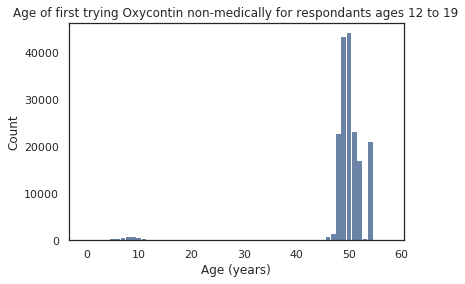

In [93]:
# Create histograms for each age group.
make_agefirst_hist(age_under_20, 'Age of first trying Oxycontin non-medically for respondants ages 12 to 19')

I'm very confused why the under-20 group reported trying Oxycontin in their 40s and 50s. I can't find a reason for this in the codebooks, so I'll decline from analyzing this result too closely. This probably threw off the previous histograms that weren't grouped by age. This also seems to be the age group that contributes the very young reported ages to the histograms that weren't grouped by age.

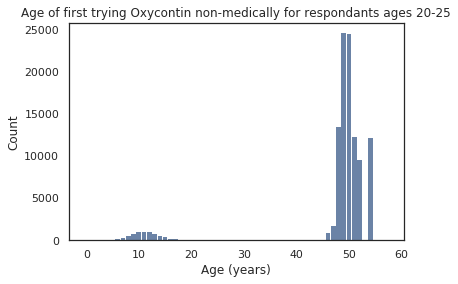

In [101]:
make_agefirst_hist(age_early_20s, 'Age of first trying Oxycontin non-medically for respondants ages 20-25')

Again, there are a lot of people in this age group reporting trying Oxycontin for the first time at ages much older than they were when they took the survey.

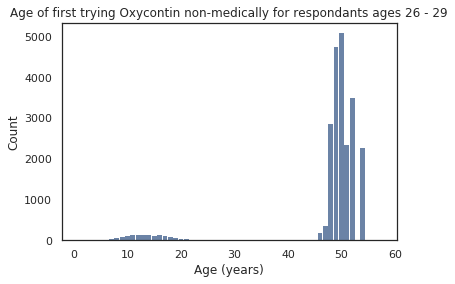

In [100]:
make_agefirst_hist(age_12, 'Age of first trying Oxycontin non-medically for respondants ages 26 - 29')

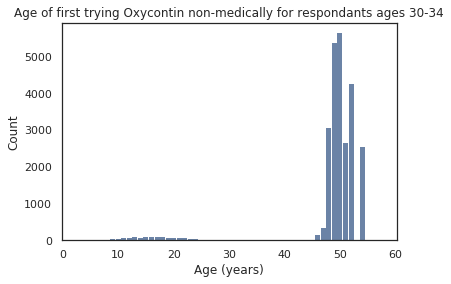

In [102]:
make_agefirst_hist(age_13, 'Age of first trying Oxycontin non-medically for respondants ages 30-34')

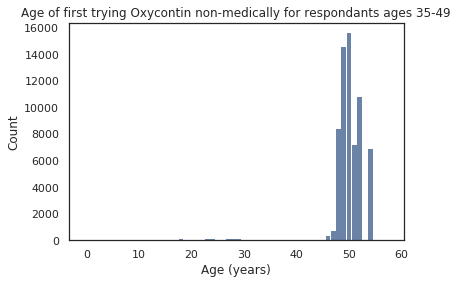

In [103]:
make_agefirst_hist(age_14, 'Age of first trying Oxycontin non-medically for respondants ages 35-49')

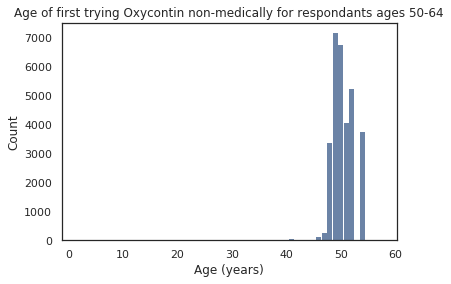

In [105]:
make_agefirst_hist(age_15, 'Age of first trying Oxycontin non-medically for respondants ages 50-64')

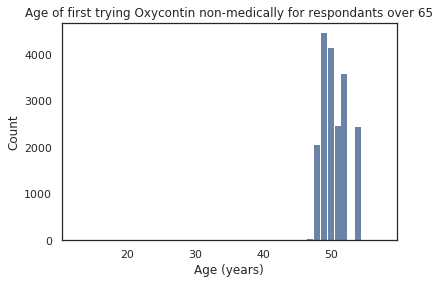

In [106]:
make_agefirst_hist(age_16, 'Age of first trying Oxycontin non-medically for respondants over 65')

Based on inspecting these histograms and finding that a lot of data doesn't make sense for the age groups who reported it, I hestitate to draw any conclusions. I can't find a reason for this effect in the codebooks.

### Frequency of using oxycontin nonmedically

I am also interested in the amount that survey respondants used oxycontin nonmedically. Let's look at the CDF of both the number of days respondants used oxycontin in the last 12 months and the histogram of the last time since they used oxycontin nonmedically. Please note that only the surveys from 2007-2014 include this question.

([<matplotlib.axis.XTick at 0x7f5436109b00>,
 <a list of 3 Text xticklabel objects>)

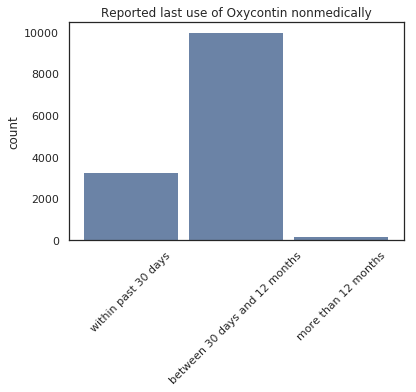

In [108]:
within_30 = (opioid_df['oxycrec'] == 1)
more_than_30 = (opioid_df['oxycrec'] == 2)
more_than_12 = (opioid_df['oxycrec'] == 3)
valid = opioid_df[within_30 | more_than_30 | more_than_12]
valid['oxycrec'].replace([91, 81], 4)
time_since_hist = ts.Hist(valid['oxycrec'])
thinkplot.hist(time_since_hist)
plt.ylabel('count')
plt.title('Reported last use of Oxycontin nonmedically')
ticks = [1, 2, 3]
labels = ['within past 30 days', 'between 30 days and 12 months', 'more than 12 months']
plt.xticks(ticks, labels, rotation=45)

Note that earlier I replaced the codes for 'NEVER USED OXYCONTIN' and 'DID NOT USE OXYCONTIN IN THE PAST 12 MONTHS' for column 'oxyyrtot' with 0s.

(711, 9)

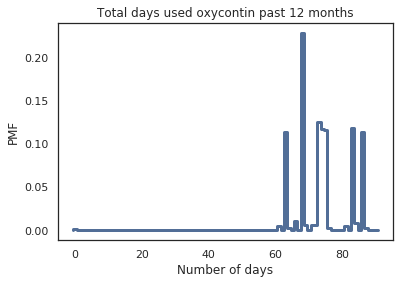

In [107]:
pmf_days_used = ts.Pmf(opioid_df['oxyyrtot'])
thinkplot.pmf(pmf_days_used)
plt.xlabel('Number of days')
plt.ylabel('PMF')
plt.title('Total days used oxycontin past 12 months')
opioid_df[opioid_df['oxyyrtot'] == 0].shape

Text(0.5, 1.0, 'Total days used oxycontin past 12 months')

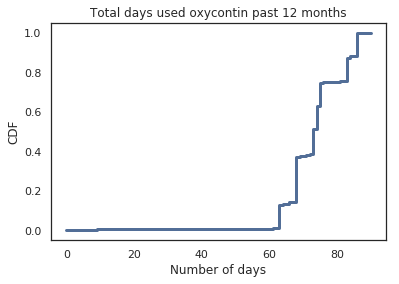

In [49]:
cdf_days_used = ts.Cdf(opioid_df['oxyyrtot'])
thinkplot.cdf(cdf_days_used)
plt.xlabel('Number of days')
plt.ylabel('CDF')
plt.title('Total days used oxycontin past 12 months')

I'm surprised by what I see here. I would have expected to see a lot of respondants reporting that they did not use oxycontin at all in the past year, or only a few times, but instead there is a large spike in frequency after 60 days. This data was for the number of days of any oxycontin use though. Let's see what the pmf and cdf of only nonmedical oxycontin use look like.

Text(0.5, 1.0, 'Total days since last used oxycontin nonmedically past 12 months')

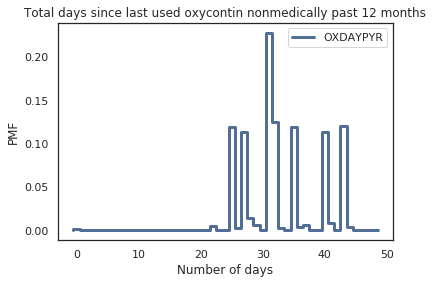

In [110]:
pmf_days_used = ts.Pmf(opioid_df['oxdaypyr'])
thinkplot.pmf(pmf_days_used, label='OXDAYPYR')
plt.xlabel('Number of days')
plt.ylabel('PMF')
plt.legend()
plt.title('Total days since last used oxycontin nonmedically past 12 months')

Text(0.5, 1.0, 'Total days used oxycontin nonmedically past 12 months')

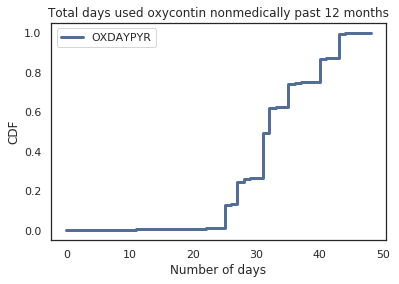

In [111]:
cdf_days_used = ts.Cdf(opioid_df['oxdaypyr'])
thinkplot.cdf(cdf_days_used, label='OXDAYPYR')
plt.xlabel('Number of days')
plt.ylabel('CDF')
plt.legend()
plt.title('Total days used oxycontin nonmedically past 12 months')

### Frequency of nonmedical oxycontin use by year

I also want to investigate if there is any relationship between the survey year and the number of days people reported using opioids in the past year nonmedically.

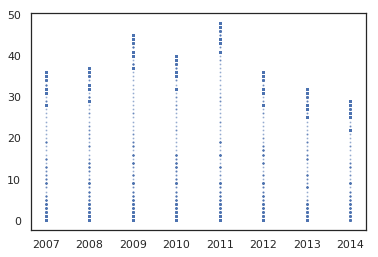

In [52]:
subset = opioid_df.dropna(subset=['oxdaypyr'])
plt.plot(subset['year'], subset['oxdaypyr'], 'o', markersize=1, alpha=0.4)

The data is quantized by year, so it looks a little strange, but it's interesting to note that there appear to be more dense clusters around lower numbers of days and higher numbers of days in each year.

It appears from these reprentations of the data that people tend to misuse oxycontin nonmedically for a large number of days. I would have expected to see some people report larger numbers of days than 50.